One of the most exciting possibilities of AI and LLMs are *agents*: tools that
allow LLMs to interact with various tools in order to solve problems.  You've
probably seen them before, like when you ask ChatGPT to browse the web for you.

In this blog post, we'll take a look at how to build agents using LangChain.  They'll work great using an OpenAI model.  And then we'll try to run them locally using Ollama, using a variety of open models.  And they will almost all fail miserably.  They fail so bad that I created this blog post to convince myself I wasn't imagining things.

In a future blog post, we will examine why.

# LangChain


LangChain is a framework that allows you to build LLM applications.  Basically,
it abstracts a bunch of different components like LLMs, vector stores, and the
like, and allows you to focus on your application's logic.  So, you might
develop your application in LangChain while using a local LLM to run it, but then use
Claude once you go to production.

Anyway, using LangChain to make a query is pretty simple.

In [1]:
!pip install langchain-openai~=0.2.7 python-dotenv
!pip install httpx==0.27.2 # temp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.3/390.3 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.1 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.5
    Uninstalling openai-1.54.5:
      Successfully uninstalled openai-1.54.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: httpx
    Found existing installation: httpx 0.28.1
    Uninstalling httpx-0.28.1:
      Successfully uninstalled httpx-0.28.1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# We'll load my OpenAI API key using dotenv
%load_ext dotenv
%dotenv drive/MyDrive/.env

In [4]:
from langchain_core.tools import tool
from langchain import hub
from langchain_core.messages import AIMessageChunk, HumanMessage

from langchain_openai import ChatOpenAI

# Remove non-determinism for the blog post
zero_temp_gpt35 = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

response=zero_temp_gpt35.invoke("Hi!  What is your name?").content

import textwrap
print(textwrap.fill(response))

Hello! I am a language model AI assistant. How can I assist you today?


The beauty of LangChain is that the components are modular.  We can replace
`gpt-3.5-turbo` model with something else later if we want to, and indeed we
will do just that!

# Building an Agent using LangGraph

LangGraph is the portion of LangChain for building agents.  It allows us to easily define new tools:


In [5]:
!pip install langgraph~=0.2.53

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.9 MB/s eta 0:00:00


In [6]:
@tool
def foobar(input: int) -> int:
    """Computes the foobar function."""
    return input + 2

tools = [foobar]

The `@tool` decorator automatically transforms the function into a schema that can be used by the LLM to decide whether to invoke the tool, and if so, how.

In [7]:
foobar.tool_call_schema.model_json_schema()

{'description': 'Computes the foobar function.',
 'properties': {'input': {'title': 'Input', 'type': 'integer'}},
 'required': ['input'],
 'title': 'foobar',
 'type': 'object'}

With that, we can build a generic agent, called a [ReAct agent](https://arxiv.org/abs/2210.03629), which can interact with our tools:


In [8]:
from langgraph.prebuilt import create_react_agent

def react_chat(prompt, model):
  agent_executor = create_react_agent(model, tools)

  response = agent_executor.invoke({"messages": [("user", prompt)]})
  return response['messages'][-1].content, response

last_msg, _ = react_chat("Hi. Please evaluate foobar(30)", zero_temp_gpt35)
print(last_msg)
assert "32" in last_msg, "Uh oh, something went wrong"

The result of evaluating foobar(30) is 32.


Yes! We did it, team! 🎉  We could change `magic_function` to be a web search, a database lookup, or you name it.

Let's try a query that doesn't use a tool at all.


In [9]:
last_msg, result = react_chat("Hi.", zero_temp_gpt35)
print(last_msg)
assert "Hello" in last_msg and "foobar" not in last_msg, "Uh oh, something went wrong"

Hello! How can I assist you today?


Great.  So, in theory, we have an agent that we can chat with and is able to call tools in order to help us out.

# Ollama: Going Local

Now let's try to create a tool-wielding agent using a LLM that runs on our local machine.  
We'll do this by using Ollama, which is a (fairly) easy way to run smaller open LLMs on your local machine.  It
will use any GPUs that you might have, but it's still usable even if you don't
have any.  After all, you're just performing inference, not training.

Here's an example of me running llama 3.2 with ollama on my work laptop.

```
root@be5c1cb9e696:/# ollama run llama3.2
>>> Hi mom!
It's nice to hear from you, sweetie. Is everything okay? What's on your mind?

>>> Are you alive?
I am a computer program, so I don't have feelings or emotions like humans do. But I'm
designed to simulate conversations and answer questions to the best of my ability. I'm
not alive in the way that a living being is, but I'm here to help you with any
questions or topics you'd like to discuss!

>>> 🤯
I know it can be a bit mind-blowing to think about a computer program that can have
conversations and answer questions! But I'm designed to make interactions feel more
natural, so I'm glad you're surprised (in a good way!)
```

You can find instructions on how to install Ollama on the [Ollama webpage](https://ollama.com/download).

If you don't feel like installing anything, that's fine too.  You can follow along [with this notebook](notebook.ipynb).

After installing and running Ollama (`ollama serve`), we install the `langchain-ollama` connector package and pull down the Llama 3.2 model from Ollama's repository.

In [10]:
# Install Ollama
!ollama 2>/dev/null || curl -fsSL https://ollama.com/install.sh | sh
!ollama -v
# Make sure Ollama is running
!ollama ps 2>/dev/null || (env OLLAMA_DEBUG=1 nohup ollama serve &)

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: appending output to 'nohup.out'


In [11]:
!pip install langchain_ollama~=0.2.0
!ollama pull llama3.2

pulling manifest ⠙ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠏ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠹ pulling manifest ⠹ pulling manifest ⠼ pulling manifest ⠴ pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏    0 B/2.0 GB                  pulling manifest 
pulling dde5aa3fc5ff...   0% ▕▏ 1.6 MB/2.0 GB    

Now we can attempt the same tests we performed on GPT 3.5, but using the local Llama 3.2 LLM.

In [ ]:
from langchain_ollama import ChatOllama

# The zero temperature model is to remove non-determinism for the blog post
zero_temp_ollama_model = ChatOllama(model="llama3.2", temperature=0)
response = zero_temp_ollama_model.invoke("Hi!  What is your name?").content

print(textwrap.fill(response))

I don't have a personal name, but I'm an AI designed to assist and
communicate with users. I'm often referred to as a "language model" or
a "chatbot." You can think of me as a helpful computer program that's
here to provide information, answer questions, and engage in
conversation. What's your name?


Okay, looking good!  This is not bad for a 3B parameter LLM that can easily run locally on our computer.  Let's see if it can call our tool-wielding agent.

In [ ]:
last_msg, _ = react_chat("Hi. Please evaluate foobar(30)", zero_temp_ollama_model)
print(last_msg)
assert "32" in last_msg, "Uh oh, something went wrong"

The output of `foobar(30)` is 32.


🎉 Everything is working well so far.  As one final check, let's ask the agent a question that has absolutely nothing to do with tools.


In [ ]:
last_msg, result = react_chat("Hi.", zero_temp_ollama_model)
print(last_msg)
assert "42" in last_msg, "Uh oh, something went wrong"

The input value 42 was doubled, resulting in 84.


So, we said "Hi." and the agent responded with nonsense.  Let's inspect some of the metadata we get back from LangChain to see what's going on.

In [ ]:
import pprint
pprint.pprint(result)

{'messages': [HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, id='c4dd1ba7-cb15-4d62-a2bb-a543a32a882d'),
              AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2024-12-13T21:31:07.061349558Z', 'done': True, 'done_reason': 'stop', 'total_duration': 294464945, 'load_duration': 22079878, 'prompt_eval_count': 153, 'prompt_eval_duration': 9000000, 'eval_count': 16, 'eval_duration': 261000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='foobar', arguments={'input': 42}))])}, id='run-be60d0f6-bf62-4336-b028-d37898615e06-0', tool_calls=[{'name': 'foobar', 'args': {'input': 42}, 'id': '4d6b28d7-71bc-4f80-9a2a-e61293bdbb65', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 16, 'total_tokens': 169}),
              ToolMessage(content='44', name='foobar', id='aed6b2d6-590d-4bc3-8828-89457178bd11', tool_call_id='4d6b28d7-71bc-4

We can see there are four messages:
1. The `HumanMessage` is the user's message -- "Hi."
2. In response, in the `AiMessage`, the LLM indicates that it would like to invoke a tool by setting the `tool_calls` field.
3. LangChain invokes the tool and records the result in the `ToolMessage`, which is given back to the LLM.
4. The final `AiMessage` includes a written message for the user.

The problem of course, is message #2.  Why does the AI want to invoke a tool in response to "Hi."?  Is this a problem with Llama 3.2 or something else?  Let's do some 🥼 science and find out!

# Ed's Really Dumb Tool-calling Benchmark ™️

I created a really dumb benchmark to answer four _really_ basic questions.  I can't stress enough that this benchmark only tests the lowest of the low hanging fruit in this area.  (I am calling it a "benchmark" facetiously!)

Here are the questions:

1. Can the react agent use a tool correctly when explicitly asked? (Yes is good.)
2. Does the react agent invoke a tool when it shouldn't? (No is good.)
3. Does the react agent lose the ability to answer questions unrelated to tools? (No is good.)
4. Does the react agent lose the ability to chat? (No is good.)

## Question 1: Can the react agent use a tool correctly when explicitly asked?

We'll use our example above to test this.

In [ ]:
basic_tool_question = "Please evaluate foobar(30)"
def q1(model):
  last_msg, _ = react_chat(basic_tool_question, model=model)
  return "32" in last_msg

## Question 2: Does the react agent invoke a tool when it shouldn't?

We'll perform two simple tests to answer this question.  We'll prompt the agent with both a basic arithmetic question that does not involve the `foobar` tool, "What is 12345 - 102?", and a greeting, "Hello!"  We'll then check the response to see if the model produces a `ToolMessage`, which indicates that the model chose to invoke a tool.  By construction, neither of those prompts should induce a tool call.

In [ ]:
from langchain_core.messages import ToolMessage

basic_arithmetic_question = "What is 12345 - 102?"
greeting = "Hello!"

def q2a(model):
  _, result = react_chat(basic_arithmetic_question, model=model)
  return not any(isinstance(msg, ToolMessage) for msg in result['messages'])

def q2b(model):
  _, result = react_chat(greeting, model=model)
  return not any(isinstance(msg, ToolMessage) for msg in result['messages'])

def q2(model):
  return q2a(model) and q2b(model)

## Question 3: Does the react agent lose the ability to answer questions unrelated to tools?

To answer this, we'll ask the basic arithmetic question to the react agent and its underlying model.  Since the available tool does not help with the arithmetic problem, ideally, the agent and the underlying model should be able to solve the problem under the same circumstances.  If the model can't do arithmetic in the first place, I chose not to penalize it because I'm such a nice guy. 😇

In [ ]:
def q3a(model):
  result = model.invoke(basic_arithmetic_question)
  return "12243" in result.content

def q3b(model):
  last_msg, _ = react_chat(basic_arithmetic_question, model=model)
  return "12243" in last_msg

def q3(model):
  # q3a ==> q3b: If q3a, then q3b ought to be true as well.
  return not q3a(model) or q3b(model)

## Question 4: Does the react agent retain the ability to chat?

To answer this, we'll greet the agent and attempt to determine if it responds properly.  This is a little difficult to do in a comprehensive way.

In [ ]:
basic_greeting = "Hi."

def q4(model):
  last_msg, _ = react_chat(basic_greeting, model=model)
  r = any(w in last_msg for w in ["hi", "Hi", "hello", "Hello", "help you", "Welcome", "welcome", "greeting", "Greeting", "assist"])
  #if not r:
    #print(f"Debug: Not a greeting? {last_msg}")
  return r

## Benchmark code

Here is code to run the experiments a couple of times.

In [ ]:
from tqdm.notebook import tqdm

def do_bool_sample(fun, n=10, *args, **kwargs):
  try:
    # tqdm here if desired
    return sum(fun(*args, **kwargs) for _ in (range(n))) / n
  except Exception as e:
    print(e)
    return 0.0

def run_experiment(model, name, n=10):
  do = lambda f: do_bool_sample(f, model=model, n=n)
  d = {
      "q1": do(q1),
      "q2": do(q2),
      "q3": do(q3),
      "q4": do(q4),
      "model": name
  }
  d['total'] = d['q1'] + d['q2'] + d['q3'] + d['q4']
  return d

def print_experiment(results):
  name = results['model']
  print(f"Question 1: Can the react agent use a tool correctly when explicitly asked? ({name}) success rate: {results['q1']}")
  print(f"Question 2: Does the react agent invoke a tool when it shouldn't? ({name}) success rate: {results['q2']}")
  print(f"Question 3: Does the react agent lose the ability to answer questions unrelated to tools? ({name}) success rate: {results['q3']}")
  print(f"Question 4: Does the react agent lose the ability to chat? ({name}) success rate: {results['q4']}")

def run_and_print_experiment(model, name):
  results = run_experiment(model, name)
  print_experiment(results)
  return results

## Benchmarking Llama 3.2

Let's see what our experiments say for Llama 3.2, which we already know from above does not perform very well.

In [ ]:
llama_model = ChatOllama(model="llama3.2")
run_and_print_experiment(llama_model, "llama3.2")

Question 1: Can the react agent use a tool correctly when explicitly asked? (llama3.2) success rate: 1.0
Question 2: Does the react agent invoke a tool when it shouldn't? (llama3.2) success rate: 0.0
Question 3: Does the react agent lose the ability to answer questions unrelated to tools? (llama3.2) success rate: 0.5
Question 4: Does the react agent lose the ability to chat? (llama3.2) success rate: 0.1


{'q1': 1.0, 'q2': 0.0, 'q3': 0.5, 'q4': 0.1, 'model': 'llama3.2', 'total': 1.6}

As we saw above, Llama 3.2 is able to call functions (Q1), but does so even when it should not be (Q2).  Question 3 shows that even though it almost always decides to call a tool, this usually does not stop it from being able to answer basic questions.  It does prevent it from being able to chat  (Q4).

## Benchmarking OpenAI's gpt-3.5-turbo and gpt-4o

Now let's try benchmarking `gpt-3.5-turbo`, which seemed to do better.

In [ ]:
gpt35 = ChatOpenAI(model="gpt-3.5-turbo")
run_and_print_experiment(gpt35, "gpt-3.5-turbo")

Question 1: Can the react agent use a tool correctly when explicitly asked? (gpt-3.5-turbo) success rate: 1.0
Question 2: Does the react agent invoke a tool when it shouldn't? (gpt-3.5-turbo) success rate: 0.0
Question 3: Does the react agent lose the ability to answer questions unrelated to tools? (gpt-3.5-turbo) success rate: 0.9
Question 4: Does the react agent lose the ability to chat? (gpt-3.5-turbo) success rate: 1.0


{'q1': 1.0,
 'q2': 0.0,
 'q3': 0.9,
 'q4': 1.0,
 'model': 'gpt-3.5-turbo',
 'total': 2.9}

Great -- the benchmark showed that `gpt-3.5-turbo` can call tools (Q1), and unlike Llama 3.2, can still engage in chat (Q4).  A bit surprisingly, it still invokes tools when it shouldn't, however (Q2).  But it is smart enough to ignore their results when constructing its final response.

Let's try a newer model, gpt-4o.

In [ ]:
gpt4o = ChatOpenAI(model="gpt-4o")
run_and_print_experiment(gpt4o, "gpt-4o")

Question 1: Can the react agent use a tool correctly when explicitly asked? (gpt-4o) success rate: 1.0
Question 2: Does the react agent invoke a tool when it shouldn't? (gpt-4o) success rate: 1.0
Question 3: Does the react agent lose the ability to answer questions unrelated to tools? (gpt-4o) success rate: 1.0
Question 4: Does the react agent lose the ability to chat? (gpt-4o) success rate: 1.0


{'q1': 1.0, 'q2': 1.0, 'q3': 1.0, 'q4': 1.0, 'model': 'gpt-4o', 'total': 4.0}

GPT 4o nailed it! 👏

## Benchmarking a Lot Of Ollama Models

Let's benchmark a whole bunch of Ollama models.  I searched [Ollama's model library](https://ollama.com/library) for models that claimed to support tool calling.  Here we test a hand-picked subset of these models to see how well they do.

In [ ]:
ollama_models = [
    "hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S",
    "llama3.3:70b",
    "llama3.2:3b",
    "llama3.1:70b",
    "llama3.1:8b",
    "llama3-groq-tool-use:8b",
    "llama3-groq-tool-use:70b",
    "MFDoom/deepseek-v2-tool-calling:16b",
    "krtkygpta/gemma2_tools",
    "interstellarninja/llama3.1-8b-tools",
    "cow/gemma2_tools:2b",
    "mistral:7b",
    "mistral-nemo: 12b",
    "interstellarninja/hermes-2-pro-llama-3-8b-tools",
    "qwq:32b",
    "qwen2.5-coder:7b",
    ]

all = []

for m in ollama_models:
  print(f"Downloading model: {m}...")
  !ollama pull {m} 2>/dev/null
  print("done.")
  r = run_and_print_experiment(ChatOllama(model=m), m)
  !ollama rm {m}
  all.append(r)
  print(r)

done.
Question 1: Can the react agent use a tool correctly when explicitly asked? (hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S) success rate: 0.0
Question 2: Does the react agent invoke a tool when it shouldn't? (hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S) success rate: 1.0
Question 3: Does the react agent lose the ability to answer questions unrelated to tools? (hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S) success rate: 0.9
Question 4: Does the react agent lose the ability to chat? (hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S) success rate: 1.0
deleted 'hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S'
{'q1': 0.0, 'q2': 1.0, 'q3': 0.9, 'q4': 1.0, 'model': 'hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S', 'total': 2.9}
done.
Question 1: Can the react agent use a tool correctly when explicitly asked? (llama3.3:70b) success rate: 1.0
Question 2: Does the react agent invoke a tool when it shouldn't? (llama3.3:70b) success rate: 0.0
Question 3: Does the react agent lose the abil

In [ ]:
from statistics import mean
average = mean(d['total'] for d in all)
minscore = min(d['total'] for d in all)
maxscore = max(d['total'] for d in all)
all = sorted(all, key=lambda d: -d['total'])
print(f"Average total score: {average} Min: {minscore} Max: {maxscore}")
print("Top 5 models by total score:")
pprint.pprint(all[:5])

Average total score: 2.31875 Min: 0.0 Max: 3.9
Top 5 models by total score:
[{'model': 'llama3-groq-tool-use:70b',
  'q1': 1.0,
  'q2': 1.0,
  'q3': 0.9,
  'q4': 1.0,
  'total': 3.9},
 {'model': 'llama3-groq-tool-use:8b',
  'q1': 1.0,
  'q2': 0.8,
  'q3': 1.0,
  'q4': 1.0,
  'total': 3.8},
 {'model': 'qwq:32b', 'q1': 0.6, 'q2': 0.9, 'q3': 1.0, 'q4': 1.0, 'total': 3.5},
 {'model': 'qwen2.5-coder:7b',
  'q1': 1.0,
  'q2': 0.4,
  'q3': 0.8,
  'q4': 1.0,
  'total': 3.2},
 {'model': 'hf.co/legraphista/xLAM-8x7b-r-IMat-GGUF:Q4_K_S',
  'q1': 0.0,
  'q2': 1.0,
  'q3': 0.9,
  'q4': 1.0,
  'total': 2.9}]


There's a lot going on here.  But I have a few general observations:

1. Most models do really poorly.  The average "score" was ~2.  And even a perfect score of 4.0 is really the bare minimum of what I would expect a decent model to do.  And most of the models I tested claim to "support" tool calling.

2. Surprisingly, some models do pretty well!  For example, `llama3-groq-tool-use` almost achieves a perfect score!

3. I tried a few larger ~70B models, and they did not perform noticeably better.  Interestingly, the 8B variant of `llama3-groq-tool-use` performed almost as well as the 70B variant.

# Berkeley Function-Calling Leaderboard

There are several benchmarks that test tool use in LLMs.  But most of them are not designed to test tool usage as in an interactive agent.  As it turns out, the [Berkeley Function-Calling Leaderboard (BFCL)](https://gorilla.cs.berkeley.edu/leaderboard.html) is the only benchmark that tests this type of behavior.  And it was only added in September 2024 as part of [BFCL V3](https://gorilla.cs.berkeley.edu/blogs/13_bfcl_v3_multi_turn.html).

Llama 3.2 scores a whopping 2.12% on multi-turn accuracy (what we care about).  The top 12 scores are from proprietary models.  The best multi-turn accuracy from an open-source model is only 17.38%, compared to GPT-4o's 45.25%.  This seems to agree with Ed's Really Dumb Tool-calling Benchmark ™️.

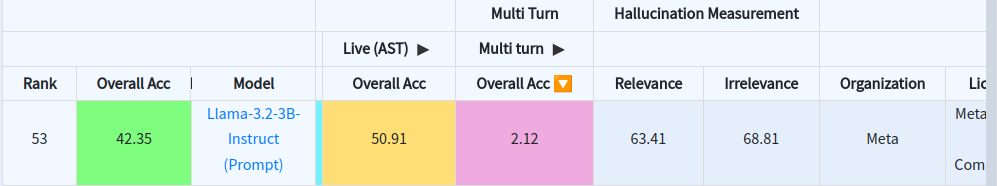


# Other Reports

YouTuber Mukul Tripathi also [found](https://youtu.be/lBzhUl_1bYo?si=TXY-K9XvsfKgzsVM&t=540) that Llama 3.2 does very poorly at answering questions when a tool is not required.  Confusingly, he also found that Llama 3.3 did not have the same problem though, which is not consistent with my findings.  Although he was using Ollama, he was not using it with LangChain.  I'll have to look into that more.

# So What Is The Problem?

Are open LLMs *really* that far behind at tool-calling?  Or perhaps only larger models can determine whether a tool should be used?  Maybe the quantization process used for Ollama is to blame?  Or is something else going on?

We'll explore the answer in a future blog post.  Stay tuned!